In [1]:
import requests
import os
import pandas as pd

import numpy as np
import re
import matplotlib.pyplot as plt
import time
from bs4 import BeautifulSoup as bs 
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime

from pathlib import Path

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
#!ls
os.chdir("/content/drive/My Drive/19-20/Spring/Data88/Supreme_Court")
!ls

 2_col_earl_samp.json	    all_cases.tar.gz	    docs
'2_col_warren (1).gsheet'   BERT		    SupremeCourt.ipynb
'2_col_warren (2).gsheet'   big_table.json	    topic_edge_list_warren.csv
 2_col_warren.csv	    big_table_warren.json   Topic_Model
 2_col_warren.gsheet	    cache		    warren_cases
 2_col_warren.json	    Doc2Vec		    Word2Vec


Above are all the packages I'll be using. ```requests``` and ```BeautifulSoup``` are used to scrape the web. ```numpy```, ```pandas```, and ```datatime``` are used to manipulate the data into DataFrames and store that data.

```wordcloud``` is used for some exploratory data analysis that visualizes word frequency.

I created functions to scrape the website https://caselaw.findlaw.com for the text of Supreme Court decisions. The text of each decision is on its own webpage. They are linked from a directory for each year, so those links need to be harvested first.

In [0]:
def find_cases(year, force=False):
    print(f"Fetching {year}")
    cache_file = "cache/cases_by_year/" + year + ".json"
    if os.path.isfile(cache_file) and not force:
        print(f"Year {year} found in cache (Last modified: {time.ctime(os.path.getmtime(cache_file))}).")
        return pd.read_json(cache_file).sort_index()
    else:
        url = "https://caselaw.findlaw.com/court/us-supreme-court/years/" + year
        page = requests.get(url)
        soup = bs(page.content, 'html.parser')
        table = soup.find('table', attrs={'class': 'responsive-card-table unstriped'})
        if table:
            table_rows = table.find_all('tr')
            links = table.find_all('a', href=True)
            links = [link.get("href") for link in links]
            l = []
            for i in range(len(table_rows)):
                td = table_rows[i].find_all('td')
                row = [tr.text for tr in td]
                l.append(row)
            l.pop(0)
            df = pd.DataFrame(l,columns=["Description", "Date", "Docket"])
            df["Docket"] = df["Docket"].apply(lambda string : re.sub('^No. ', '', string))            
            url = url[:-4]
            df['Link'] = links
            df["Opinion"] = df["Link"].apply(case_scraper)
            df.to_json(cache_file)
            return(df)
        else:
            print(f'No results for {year}')
            return

In [0]:
def case_scraper(url):
    # Delay each download thing by 1 seconds. Don't want to overload the server or trip an automated banning.
    time.sleep(1)
    page = requests.get(url)
    soup = bs(page.content, 'html.parser')
    try:
        return soup.find('div', class_='caselawcontent').text
    except:
        print(f"Error on {url}")
        return None 

Here, ```find_cases``` finds all the links and harvests some basic metadeta from the results.

In [5]:
c2018 = find_cases("1980", force=False)

Fetching 1980
Year 1980 found in cache (Last modified: Mon Mar  9 20:15:34 2020).


In [6]:
c2018

,Description,Date,Docket,Link,Opinion
0,"AARON v. SEC, 446 U.S. 680 (1980)",1980-06-02,79-66,https://caselaw.findlaw.com/us-supreme-court/4...,\n\nUnited States Supreme Court\nAARON v. SEC(...
1,"ADAMS v. TEXAS, 448 U.S. 38 (1980)",1980-06-25,79-5175,https://caselaw.findlaw.com/us-supreme-court/4...,\n\nUnited States Supreme Court\nADAMS v. TEXA...
2,"AGINS v. TIBURON, 447 U.S. 255 (1980)",1980-06-10,79-602,https://caselaw.findlaw.com/us-supreme-court/4...,\n\nUnited States Supreme Court\nAGINS v. TIBU...
3,"ALABAMA v. DAVIS, 446 U.S. 903 (1980)",1980-04-21,79-711,https://caselaw.findlaw.com/us-supreme-court/4...,\n\nUnited States Supreme Court\nALABAMA v. DA...
4,"ALLEN v. MCCURRY, 449 U.S. 90 (1980)",1980-12-09,79-935,https://caselaw.findlaw.com/us-supreme-court/4...,\n\nUnited States Supreme Court\nALLEN v. McCU...
...,...,...,...,...,...
208,"WHITE MOUNTAIN APACHE TRIBE v. BRACKER, 448 U....",1980-06-27,78-1177,https://caselaw.findlaw.com/us-supreme-court/4...,\n\nUnited States Supreme Court\nWHITE MOUNTAI...
209,"WILLHAUCK v. FLANAGAN, 448 U.S. 1323 (1980)",1980-08-28,A-169,https://caselaw.findlaw.com/us-supreme-court/4...,\n\nUnited States Supreme Court\nWILLHAUCK v. ...
210,"WILLIAMS v. BROWN, 446 U.S. 236 (1980)",1980-04-22,78-357,https://caselaw.findlaw.com/us-supreme-court/4...,\n\nUnited States Supreme Court\nWILLIAMS v. B...
211,"WILLIAMS v. ZBARAZ, 448 U.S. 358 (1980)",1980-06-30,79-4,https://caselaw.findlaw.com/us-supreme-court/4...,\n\nUnited States Supreme Court\nWILLIAMS v. Z...


Creating an archive of all the documents

In [0]:
#!tar chvfz all_cases.tar.gz cache/cases_by_year/*

To create edge diagrams, we needed all the texts with a unique ID to be saved. The difficulty here was that there seemed to be no consistent unique identifier that worked over the entire history of the United States, as the docket numbers were not created until hundreds of years in.

Because of this, I am going by description. There are multiple documents for each case that use these description. In this case, I decided that it would be reasonable to concatonate those documents together to avoid outsized weights given to other documents simply because they are referenced many times in the administrative filings.

In [0]:
def cases_range(start=1789, end=2020):
    res = pd.DataFrame(columns=["Docket", "Opinion"])
    directory_str = "cache/cases_by_year/"
    tables = [find_cases(str(year)) for year in np.arange(start,end)]
    res = pd.concat(tables).reset_index(drop=True)
    return res
           

I want to make sure that that we have a pattern to group by that allows us to join documents

In [0]:
descriptionPattern = re.compile(r"(.+),\[^,\]+")

def get_desc(string):
    res = re.findall(r"(.+),[^,]+$", string)
    if len(res) == 0:
        return string    
    return res[0]

In [10]:
big_table = pd.DataFrame(columns=["Description", "Date", "Docket"])
big_table = cases_range(1953, 1969).dropna()

Fetching 1953
Year 1953 found in cache (Last modified: Mon Mar  9 20:14:41 2020).
Fetching 1954
Year 1954 found in cache (Last modified: Mon Mar  9 20:14:43 2020).
Fetching 1955
Year 1955 found in cache (Last modified: Mon Mar  9 20:14:44 2020).
Fetching 1956
Year 1956 found in cache (Last modified: Mon Mar  9 20:14:46 2020).
Fetching 1957
Year 1957 found in cache (Last modified: Mon Mar  9 20:14:47 2020).
Fetching 1958
Year 1958 found in cache (Last modified: Mon Mar  9 20:14:49 2020).
Fetching 1959
Year 1959 found in cache (Last modified: Mon Mar  9 20:14:51 2020).
Fetching 1960
Year 1960 found in cache (Last modified: Mon Mar  9 20:14:54 2020).
Fetching 1961
Year 1961 found in cache (Last modified: Mon Mar  9 20:14:56 2020).
Fetching 1962
Year 1962 found in cache (Last modified: Mon Mar  9 20:14:58 2020).
Fetching 1963
Year 1963 found in cache (Last modified: Mon Mar  9 20:15:00 2020).
Fetching 1964
Year 1964 found in cache (Last modified: Mon Mar  9 20:15:01 2020).
Fetching 1965
Ye

Lets check to see if the table is one large table with all the years of Supreme Court cases.

In [11]:
big_table[big_table["Description"].str.contains("ALABAMA AND MISSISSIPPI")]["Link"].iloc[0]

'https://caselaw.findlaw.com/us-supreme-court/498/9.html'

Now we have a problem of finding a primary key to use to identify the documents. 

Dockets are unique to every case, however not every case has a docket number.

Lets check to see if description names are unique

In [12]:
big_table[big_table["Description"].str.contains("ROSADO v. WYMAN")]

,Description,Date,Docket,Link,Opinion


It looks like there are multiple documents for every case. We only want the last one (the final judgement of the court). 

Now lets just take all the details of the last document.

In [0]:
big_table['Date'] =  pd.to_datetime(big_table['Date'], format='%Y-%m-%d')

In [0]:
big_table["DescTrunc"] = big_table["Description"].apply(get_desc)

In [0]:
big_table.sort_values(by=["Date"], inplace=True)
big_table.reset_index(drop=True, inplace=True)

In [16]:
big_table

,Description,Date,Docket,Link,Opinion,DescTrunc
0,"EDELMAN v. CALIFORNIA, 344 U.S. 357 (1953)",1953-01-12,85,https://caselaw.findlaw.com/us-supreme-court/3...,\n\nUnited States Supreme Court\nEDELMAN v. CA...,EDELMAN v. CALIFORNIA
1,"PENNSYLVANIA R. CO. v. O'ROURKE, 344 U.S. 334 ...",1953-01-12,60,https://caselaw.findlaw.com/us-supreme-court/3...,\n\nUnited States Supreme Court\nPENNSYLVANIA ...,PENNSYLVANIA R. CO. v. O'ROURKE
2,"LABOR BOARD v. SEVEN-UP CO., 344 U.S. 344 (1953)",1953-01-12,217,https://caselaw.findlaw.com/us-supreme-court/3...,\n\nUnited States Supreme Court\nLABOR BOARD v...,LABOR BOARD v. SEVEN-UP CO.
3,"NEW YORK v. N. Y., N. H. & H. R. CO., 344 U.S....",1953-01-12,203,https://caselaw.findlaw.com/us-supreme-court/3...,\n\nUnited States Supreme Court\nNEW YORK v. N...,"NEW YORK v. N. Y., N. H. & H. R. CO."
4,"AMERICAN TRUCKING ASSNS. v. US, 344 U.S. 298 (...",1953-01-12,26,https://caselaw.findlaw.com/us-supreme-court/3...,\n\nUnited States Supreme Court\nAMERICAN TRUC...,AMERICAN TRUCKING ASSNS. v. US
...,...,...,...,...,...,...
3400,"FTC v. TEXACO, 393 U.S. 223 (1968)",1968-12-16,24,https://caselaw.findlaw.com/us-supreme-court/3...,\n\nUnited States Supreme Court\nFTC v. TEXACO...,FTC v. TEXACO
3401,"MCARTHUR v. CLIFFORD, 393 U.S. 1002 (1968)",1968-12-16,613,https://caselaw.findlaw.com/us-supreme-court/3...,\n\nUnited States Supreme Court\nMCARTHUR v. C...,MCARTHUR v. CLIFFORD
3402,HOUSEHOLD GOODS CARRIERS' BUREAU v. UNITED STA...,1968-12-16,615,https://caselaw.findlaw.com/us-supreme-court/3...,\n\nUnited States Supreme Court\nHOUSEHOLD GOO...,HOUSEHOLD GOODS CARRIERS' BUREAU v. UNITED STATES
3403,"WILSON v. KELLEY, 393 U.S. 266 (1968)",1968-12-16,561,https://caselaw.findlaw.com/us-supreme-court/3...,\n\nUnited States Supreme Court\nWILSON v. KEL...,WILSON v. KELLEY


In [0]:
last = lambda x : list(x)[-1]
big_table = (big_table.groupby("DescTrunc")
             .agg({"Description" : last,
                   "Date" : last,
                   "Docket" : last,
                   "Opinion" : last}))

In [18]:
big_table.head()

,Description,Date,Docket,Opinion
DescTrunc,,,,
"508 CHESTNUT, INC. v. CITY OF ST. LOUIS","508 CHESTNUT, INC. v. CITY OF ST. LOUIS, 382 U...",1965-12-06,605,"\n\nUnited States Supreme Court\n508 CHESTNUT,..."
A QUANTITY OF BOOKS v. KANSAS,"A QUANTITY OF BOOKS v. KANSAS, 378 U.S. 205 (1...",1964-06-22,449,\n\nUnited States Supreme Court\nA QUANTITY OF...
A QUANTITY OF COPIES OF BOOKS v. KANSAS,"A QUANTITY OF COPIES OF BOOKS v. KANSAS, 388 U...",1967-06-12,865,\n\nUnited States Supreme Court\nA QUANTITY OF...
A. & G. STEVEDORES v. ELLERMAN LINES,"A. & G. STEVEDORES v. ELLERMAN LINES, 369 U.S....",1962-04-02,282,\n\nUnited States Supreme Court\nA. & G. STEVE...
"A., T. & S. F. R. CO. v. DIXIE CARRIERS","A., T. & S. F. R. CO. v. DIXIE CARRIERS, 355 U...",1957-12-09,60,"\n\nUnited States Supreme Court\nA., T. & S. F..."


In [0]:
big_table = big_table.dropna()

In [0]:
big_table.sort_values(by=["Date"], inplace=True)
big_table.reset_index(drop = True, inplace = True)

Now lets save it off so we can save work for later.

In [0]:
big_table.to_json("big_table_warren.json")

We want the length of the document and the top 10 percentile in length just for processing later.

In [0]:
big_table["Length"] = big_table["Opinion"].str.split().apply(lambda x: len(x))

In [117]:
big_table

,Description,Date,Docket,Opinion,Length
0,"LABOR BOARD v. SEVEN-UP CO., 344 U.S. 344 (1953)",1953-01-12,217,\n\nUnited States Supreme Court\nLABOR BOARD v...,4024
1,"EDELMAN v. CALIFORNIA, 344 U.S. 357 (1953)",1953-01-12,85,\n\nUnited States Supreme Court\nEDELMAN v. CA...,3165
2,"PENNSYLVANIA R. CO. v. O'ROURKE, 344 U.S. 334 ...",1953-01-12,60,\n\nUnited States Supreme Court\nPENNSYLVANIA ...,3213
3,"NEW YORK v. N. Y., N. H. & H. R. CO., 344 U.S....",1953-01-12,203,\n\nUnited States Supreme Court\nNEW YORK v. N...,1545
4,"SOUTH BUFFALO R. CO. v. AHERN, 344 U.S. 367 (1...",1953-01-19,179,\n\nUnited States Supreme Court\nSOUTH BUFFALO...,2574
...,...,...,...,...,...
3225,"OESTEREICH v. SELECTIVE SERVICE BD., 393 U.S. ...",1968-12-16,46,\n\nUnited States Supreme Court\nOESTEREICH v....,6662
3226,"WILSON v. KELLEY, 393 U.S. 266 (1968)",1968-12-16,561,\n\nUnited States Supreme Court\nWILSON v. KEL...,109
3227,"JOHNSON v. BENNETT, 393 U.S. 253 (1968)",1968-12-16,32,\n\nUnited States Supreme Court\nJOHNSON v. BE...,978
3228,"CLARK v. GABRIEL, 393 U.S. 256 (1968)",1968-12-16,572,\n\nUnited States Supreme Court\nCLARK v. GABR...,2672


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

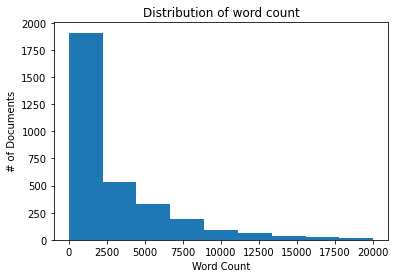

In [119]:
bins = np.linspace(0, 20000, 10)
plt.hist(big_table["Length"], bins = bins)
plt.xlabel("Word Count")
plt.ylabel("# of Documents")
plt.title("Distribution of word count");

In [120]:
np.percentile(big_table["Length"], 90)

8153.499999999996

In [0]:
table_top_len = big_table[big_table["Length"] >= np.percentile(big_table["Length"], 80)]

In [125]:
table_top_len

,Description,Date,Docket,Opinion,Length
6,"BROCK v. NORTH CAROLINA, 344 U.S. 424 (1953)",1953-02-02,34,\n\nUnited States Supreme Court\nBROCK v. NORT...,6335
13,"LUTWAK v. UNITED STATES, 344 U.S. 604 (1953)",1953-02-09,66,\n\nUnited States Supreme Court\nLUTWAK v. UNI...,6240
17,"BROWN v. ALLEN, 344 U.S. 443 (1953)",1953-02-09,32,\n\nUnited States Supreme Court\nBROWN v. ALLE...,39703
19,"UNITED STATES v. KAHRIGER, 345 U.S. 22 (1953)",1953-03-09,167,\n\nUnited States Supreme Court\nUNITED STATES...,6205
20,"RAMSPECK v. TRIAL EXAMINERS CONF., 345 U.S. 12...",1953-03-09,278,\n\nUnited States Supreme Court\nRAMSPECK v. T...,5791
...,...,...,...,...,...
3158,"JONES v. MAYER CO., 392 U.S. 409 (1968)",1968-06-17,645,\n\nUnited States Supreme Court\nJONES v. MAYE...,24762
3159,"WAINWRIGHT v. CITY OF NEW ORLEANS, 392 U.S. 59...",1968-06-17,13,\n\nUnited States Supreme Court\nWAINWRIGHT v....,5753
3185,"WILLIAMS v. RHODES, 393 U.S. 23 (1968)",1968-10-15,543,\n\nUnited States Supreme Court\nWILLIAMS v. R...,15897
3200,"EPPERSON v. ARKANSAS, 393 U.S. 97 (1968)",1968-11-12,7,\n\nUnited States Supreme Court\nEPPERSON v. A...,6691


In [127]:
print("Miranda v. Arizona:", any(table_top_len["Description"].str.contains("MIRANDA v. ARIZONA")))
print("Gideon v. Wainwright:", any(table_top_len["Description"].str.contains("GIDEON v. WAINWRIGHT")))
print("Brown v. Board:", any(table_top_len["Description"].str.contains("BROWN v. BOARD")))
print("Baker v. Carr:", any(table_top_len["Description"].str.contains("BAKER v. CARR")))
print("Loving v. Virginia:", any(table_top_len["Description"].str.contains("LOVING")))

Miranda v. Arizona: True
Gideon v. Wainwright: True
Brown v. Board: False
Baker v. Carr: True
Loving v. Virginia: False


In [0]:
big_table.to_json("big_table_warren_top.json")

We can see that this misses some important cases i.e. Brown v. Board and Loving v. Virginia. Limits in computational time and power prevent us from using all the cases we'd like to explore.

Now that we have a a large table, we can just use the Description as the unique identifier. Lets export a json that we can use for edge detection.

First, we will create a function that allows us to make a valid text file name.

In [0]:
print(f"{big_table.iloc[0]['Description']}.txt")
filename = re.sub('[^\w\-_\.\(\)]', '_', f"{big_table.iloc[0]['Description']}.txt")

LABOR BOARD v. SEVEN-UP CO., 344 U.S. 344 (1953).txt


In [0]:
filename

'LABOR_BOARD_v._SEVEN-UP_CO.__344_U.S._344_(1953).txt'

Now we can write all the files in case we need them as text files later.

In [0]:
os.mkdir("warren_cases")

In [0]:
os.chdir("warren_cases")
for index, row in big_table.iterrows():
  filename = re.sub('[^\w\-_\.\(\)]', '_', f"{big_table.iloc[index]['Description']}.txt")
  print(f"Attempting to write '{filename}'...")
  if os.path.isfile(filename):
    print(f"'{filename}' already exists. Continuing.")
    continue
  else:
    fh = open (f"{filename}", "w")
    fh.write(f"Description: {row['Description']}")
    fh.write("\n")
    fh.write(f"Date: {row['Date']}")
    fh.write("\n")
    fh.write(f"Docket: {row['Docket']}")
    fh.write("\n")
    fh.write(f"Opinion")
    fh.write("\n")
    fh.write(row["Opinion"])
    print(f"'{filename}' written.")

os.chdir("..")

Streaming output truncated to the last 5000 lines.
'KIDD_v._OHIO__358_U.S._132_(1958).txt' written.
Attempting to write 'UNITED_STATES_v._A___P_TRUCKING_CO.__358_U.S._121_(1958).txt'...
'UNITED_STATES_v._A___P_TRUCKING_CO.__358_U.S._121_(1958).txt' written.
Attempting to write 'FLAXER_v._UNITED_STATES__358_U.S._147_(1958).txt'...
'FLAXER_v._UNITED_STATES__358_U.S._147_(1958).txt' written.
Attempting to write 'LEEDOM_v._KYNE__358_U.S._184_(1958).txt'...
'LEEDOM_v._KYNE__358_U.S._184_(1958).txt' written.
Attempting to write 'AMERICAN_TRUCKING_ASSNS._v._FRISCO_CO.__358_U.S._133_(1958).txt'...
'AMERICAN_TRUCKING_ASSNS._v._FRISCO_CO.__358_U.S._133_(1958).txt' written.
Attempting to write 'JAMES_v._TODD__358_U.S._206_(1958).txt'...
'JAMES_v._TODD__358_U.S._206_(1958).txt' written.
Attempting to write 'LADNER_v._UNITED_STATES__358_U.S._169_(1958).txt'...
'LADNER_v._UNITED_STATES__358_U.S._169_(1958).txt' written.
Attempting to write 'FLEMMING_v._FLORIDA_CITRUS_EXCH.__358_U.S._153_(1958).txt'.

In [0]:
big_table[["Description", "Opinion"]].to_json("2_col_earl.json")

In [0]:
import string
punc_remove_table = str.maketrans('', '', string.punctuation)

stripped_big_table = big_table.copy()
stripped_big_table["Opinion"] = big_table["Opinion"].apply((lambda x : x.translate(punc_remove_table)))

In [0]:
stripped_big_table = stripped_big_table[["Description", "Opinion"]].rename(columns = {"Description" : "label", "Opinion" : "text"})

In [0]:
stripped_big_table

,label,text
0,"LABOR BOARD v. SEVEN-UP CO., 344 U.S. 344 (1953)",\n\nUnited States Supreme Court\nLABOR BOARD v...
1,"EDELMAN v. CALIFORNIA, 344 U.S. 357 (1953)",\n\nUnited States Supreme Court\nEDELMAN v CAL...
2,"PENNSYLVANIA R. CO. v. O'ROURKE, 344 U.S. 334 ...",\n\nUnited States Supreme Court\nPENNSYLVANIA ...
3,"NEW YORK v. N. Y., N. H. & H. R. CO., 344 U.S....",\n\nUnited States Supreme Court\nNEW YORK v N ...
4,"SOUTH BUFFALO R. CO. v. AHERN, 344 U.S. 367 (1...",\n\nUnited States Supreme Court\nSOUTH BUFFALO...
...,...,...
3225,"OESTEREICH v. SELECTIVE SERVICE BD., 393 U.S. ...",\n\nUnited States Supreme Court\nOESTEREICH v ...
3226,"WILSON v. KELLEY, 393 U.S. 266 (1968)",\n\nUnited States Supreme Court\nWILSON v KELL...
3227,"JOHNSON v. BENNETT, 393 U.S. 253 (1968)",\n\nUnited States Supreme Court\nJOHNSON v BEN...
3228,"CLARK v. GABRIEL, 393 U.S. 256 (1968)",\n\nUnited States Supreme Court\nCLARK v GABRI...


In [0]:
stripped_big_table.to_csv("2_col_warren.csv", index=False)

Now, I brought this into a modified version of the edge creation notebook that can handle json files.

_Note: Using CSV failed miserably as it was impossible to properly quote the documents. JSON worked fine._

The edge creation notebook for topic modelling does successfully work for all cases, however the mapping software for visualization does not function on my personal PC with so many nodes and edges. As a result, we are forced to take a representative sample of all cases.

In [0]:
big_table_sample = big_table.sample(1000, random_state=42)

In [0]:
big_table_sample

,Description,Date,Docket,Opinion
449,"MALLORY v. UNITED STATES, 354 U.S. 449 (1957)",1957-06-24,521,\n\nUnited States Supreme Court\nMALLORY v. UN...
2098,"MAMULA v. UNITED STEELWORKERS OF AMERICA, 379 ...",1964-10-19,327,\n\nUnited States Supreme Court\nMAMULA v. UNI...
299,"GRIFFIN v. ILLINOIS, 351 U.S. 12 (1956)",1956-04-23,95,\n\nUnited States Supreme Court\nGRIFFIN v. IL...
3070,"NLRB v. MARINE WORKERS, 391 U.S. 418 (1968)",1968-05-27,796,\n\nUnited States Supreme Court\nNLRB v. MARIN...
1590,"MISSOURI v. CLAY, 371 U.S. 577 (1963)",1963-01-21,645,\n\nUnited States Supreme Court\nBENDIX CORPOR...
...,...,...,...,...
677,"CARITATIVO v. CALIFORNIA, 357 U.S. 549 (1958)",1958-06-30,561,\n\nUnited States Supreme Court\nCARITATIVO v....
2374,"RAINSBERGER v. NEVADA, 382 U.S. 455 (1966)",1966-01-31,368,\n\nUnited States Supreme Court\nRAINSBERGER v...
2411,"KENT v. UNITED STATES, 383 U.S. 541 (1966)",1966-03-21,104,\n\nUnited States Supreme Court\nKENT v. UNITE...
238,"ELLIS v. DIXON, 349 U.S. 458 (1955)",1955-06-06,20,\n\nUnited States Supreme Court\nELLIS v. DIXO...


Now we can sample use this sample of 1000 random cases to see what sort of topics the Supreme Court will take. We export it to be converted into a diagram.

In [0]:
big_table[["Description", "Opinion"]].to_json("2_col_earl_samp.json")

In [0]:
os.getcwd()
!ls

2_col_earl_samp.json   cache			   Topic_Model
2_col_warren.json      Doc2Vec			   warren_cases
all_cases.tar.gz       docs			   Word2Vec
big_table.json	       SupremeCourt.ipynb
big_table_warren.json  topic_edge_list_warren.csv


In [0]:
comment_words = ' '
stopwords = set(STOPWORDS) 
stopwords.update(["court", "see", "statute", "pp"])  

In [0]:
# iterate through the csv file 
for val in big_table["Opinion"]: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 1920, height = 1080, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

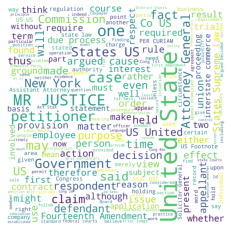

In [0]:
text = stripped_big_table['text'].values 

wordcloud = WordCloud(width = 2000, height = 2000, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate("\n".join(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
# plot the WordCloud image                        
plt.figure(figsize = (100, 100), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 